In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../modules')
from utils import climate
import matplotlib.pyplot as plt
import geopandas as gpd

In [201]:
dir_data = '../data/eca_data/'

In [202]:
stations_pres = climate.eca_read_station_like_file("ECA_blend_station_pp.txt", directory = dir_data)
stations_prec = climate.eca_read_station_like_file("ECA_blend_station_rr.txt", directory = dir_data)
stations_tavg = climate.eca_read_station_like_file("ECA_blend_station_tg.txt", directory = dir_data)
stations_rads = climate.eca_read_station_like_file("ECA_blend_station_qq.txt", directory = dir_data)

stations_dict = {'pp' : stations_pres, 'rr' : stations_prec, 'tg' : stations_tavg, 'qq' : stations_rads}

stations = pd.concat([stations_pres, stations_prec, stations_tavg, stations_rads]).drop_duplicates().reset_index(drop=True)

In [203]:
np.sum(np.array(stations_rads["STAID"]) == 308)

0

In [204]:
dataframes = []
for measure, stations in stations_dict.items():
    for _, row in stations.iterrows():
        if(_ % 500 == 0):
            print(_)
        stat_id = row['STAID']
        filename = "ECA_blend_%s/%s_STAID%06i.txt" % (measure, measure.upper(),stat_id)
        df = climate.eca_read_station_like_file(filename, directory = dir_data)
        df['DATE'] = pd.to_datetime(df['DATE'], format="%Y%m%d")
        
        df = df[df['DATE'] > '2000-01-01']

        if df.empty:
            continue

        df[df == -9999] = np.nan
        df.dropna(axis=0, inplace=True)
        df = df[['STAID', 'DATE', measure.upper()]]

        df.rename({'STAID': 'station_id', 'DATE' : 'date', measure.upper() : 'value' }, axis=1, inplace=True)
        df['measure'] = measure
        df.set_index(['station_id', 'measure', 'date'], drop=True, inplace=True)
        
        dataframes.append(df)
dataframes = pd.concat(dataframes, axis=0)

0
500
1000
1500
2000
2500
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
0
500
1000
1500
2000


In [699]:
dataframes.to_parquet('../data/eca_data/eca_data_2000s.parquet', compression='gzip')

In [706]:
measure_x = 'pp'
measure_y = 'tg'

# Merge the dataframes with suffixes to distinguish the columns
subset_rrtg = pd.merge(dataframes.xs(measure_x, level='measure'),
                       dataframes.xs(measure_y, level='measure'),
                       left_index=True, right_index=True, how='inner',
                       suffixes=('_pp', '_tg'))

# Rename the columns to the desired names
subset_rrtg.columns = ["pressure", "temperature"]

# remove the dates with radiation = 0
#subset_rrtg = subset_rrtg[subset_rrtg["precipitation"] > 0]


# remove the dates with pressure less 1000
# subset_rrtg = subset_rrtg[subset_rrtg["pressure"] > 9800]
# Display the resulting DataFrame
print(subset_rrtg.head())

                       pressure  temperature
station_id date                             
5          2000-01-02   10127.0         25.0
           2000-01-03   10073.0         11.0
           2000-01-04   10007.0         36.0
           2000-01-05   10089.0          2.0
           2000-01-06   10059.0         34.0


In [707]:
# get all station ids in the subset
stations_ids = subset_rrtg.index.get_level_values('station_id').unique()
print(len(stations_ids))

2264


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

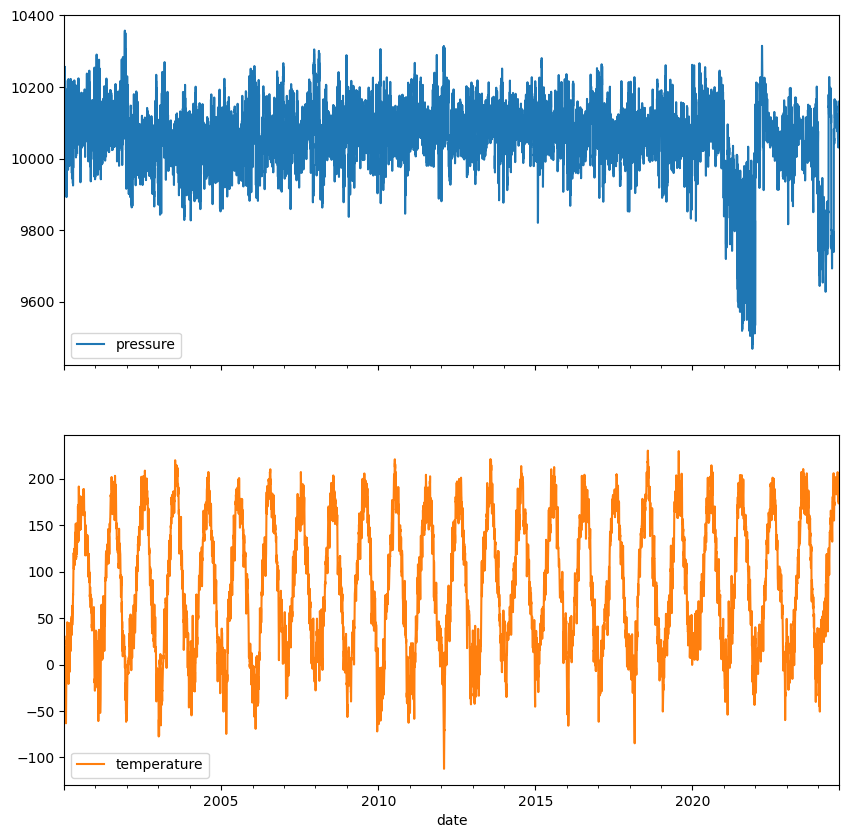

In [708]:
# plot over time the average over station of temperature and radiation
subset_rrtg.groupby('date').mean().plot(subplots=True, figsize=(10, 10))

In [711]:
loc_dict = {}
for station_id in stations_ids:
    loc_dict[station_id] = stations_pres[stations_pres['STAID'] == station_id][['LAT', 'LON']].values[0]

/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_26277/454024279.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


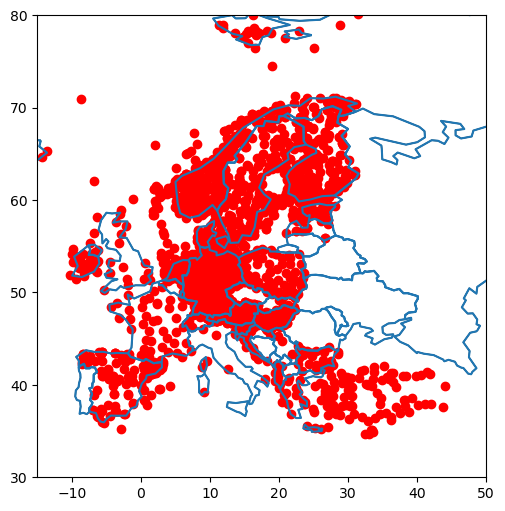

In [712]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

fig, ax = plt.subplots(figsize=(10,6))
europe.boundary.plot(ax=ax)
europe.plot(ax=ax, color='white', edgecolor='black')

# plot all the stations
for station_id, loc in loc_dict.items():
    plt.scatter(loc[1], loc[0], color='red')

plt.xlim(-15, 50)
plt.ylim(30, 80)
plt.show()

In [713]:
# # find station where the latitude is between 40 and 50 and longitude is between 0 and 10 using loc_dict
# stations_selected = []
# min_lat = 47
# max_lat = 48

# min_lon = 12
# max_lon = 13

# for station_id, loc in loc_dict.items():
#     if loc[0] > min_lat and loc[0] < max_lat and loc[1] > min_lon and loc[1] < max_lon:
#         stations_selected.append(station_id)
# len(stations_selected)

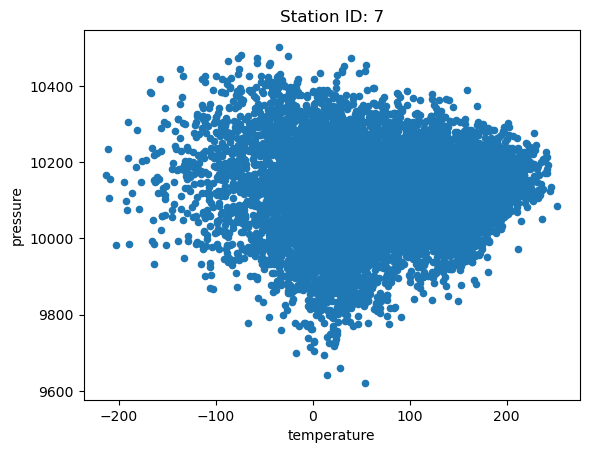

[59.43333333 13.33333333]


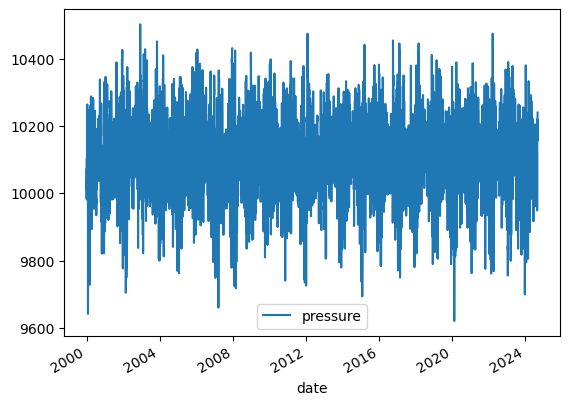

In [715]:
# plot the data for station_id = 246
station_id = list(loc_dict.keys())[1]
subset_rrtg.loc[station_id].plot.scatter(y="pressure", x="temperature")
plt.title(f"Station ID: {station_id}")
plt.show()

# #print the station location
print(loc_dict[station_id])

# plot only precipitation data
subset_rrtg.loc[station_id].plot(y="pressure")
#plt.xlim(np.datetime64('2020-06-01'), np.datetime64('2022-09-01'))
plt.show()

In [760]:
from scipy.stats import gaussian_kde
from scipy.integrate import dblquad

# define a logaritmic function that returns zero for zero values and works for arrays
def logaritmic(x):
    return np.where(x == 0, 0, np.log(x))

def rolling_kde(df, window='30D'):
    kde_results = []

    # Rolling window
    rolling_windows = df.rolling(window)

    for window_df in rolling_windows:
        if len(window_df) <= 2:
            kde_results.append(None)
            continue

        # Perform KDE
        values = window_df[['pressure', 'temperature']].dropna().values.T
        kde = gaussian_kde(values)
        kde_results.append(kde)

    return kde_results

# Function to compute mutual information from KDE
def compute_mutual_information_variance(kde, x_range, y_range):
    # Joint PDF
    def joint_pdf(x, y):
        return kde(np.vstack([x, y]))

    # Marginal PDFs
    def marginal_pdf_x(x):
        return kde(np.vstack([x, np.zeros_like(x)]))

    def marginal_pdf_y(y):
        return kde(np.vstack([np.zeros_like(y), y]))

    # Integrand for mutual information
    def integrand_mi(x, y):
        p_xy = joint_pdf(x, y)
        p_x = marginal_pdf_x(x)
        p_y = marginal_pdf_y(y)
        return p_xy * logaritmic(p_xy / (p_x * p_y))
    
    # Integrand for variance
    def integrand_var(x, y):
        p_xy = joint_pdf(x, y)
        p_x = marginal_pdf_x(x)
        p_y = marginal_pdf_y(y)
        return p_xy * (logaritmic(p_xy / (p_x * p_y)))**2

    # Numerical integration
    mutual_info, _ = dblquad(integrand_mi, x_range[0], x_range[1], lambda x: y_range[0], lambda x: y_range[1])
    variance, _ = dblquad(integrand_var, x_range[0], x_range[1], lambda x: y_range[0], lambda x: y_range[1])
    return variance, mutual_info


def rolling_mi_kde(df, window='30D'):
    mi_results = []

    rolling_windows = df.rolling(window)

    for window_df in rolling_windows:
        if len(window_df) <= 2:
            mi_results.append(None)
            continue

        # Perform KDE
        values = window_df[['pressure', 'temperature']].dropna().values.T
        kde = gaussian_kde(values)
        
        xrange = np.array([np.min(window_df['pressure']), np.max(window_df['pressure'])])
        yrange = np.array([np.min(window_df['temperature']), np.max(window_df['temperature'])])

        var, mi = compute_mutual_information_variance(kde, xrange, yrange)
        mi_results.append([var, mi])

    return mi_results

In [772]:
station_id = 5
rolling_windows = group_indexed.rolling("30D")

for window_df in rolling_windows:
    if len(window_df) <= 2:
        continue
    
    values = window_df[['pressure', 'temperature']].dropna().values.T
    kde = gaussian_kde(values)

    xrange = np.array([np.min(window_df['pressure']), np.max(window_df['pressure'])])
    yrange = np.array([np.min(window_df['temperature']), np.max(window_df['temperature'])])

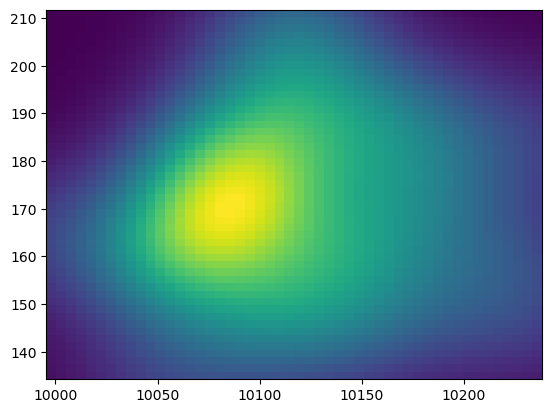

ValueError: points have dimension 1, dataset has dimension 2

In [ ]:
xrange_all = np.linspace(xrange[0], xrange[1], 50)
yrange_all = np.linspace(yrange[0], yrange[1], 50)

X, Y = np.meshgrid(xrange_all, yrange_all)

joint_pdf = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
plt.pcolormesh(X, Y, joint_pdf, cmap='viridis')
plt.show()



In [761]:
mutual_info = {}
mutual_fano = {}
correlation_coeff = {}

mutual_var_mi_nl = {}

for station_id, group in subset_rrtg.groupby('station_id'):
    print(station_id)
    group_indexed = group.reset_index(level='station_id', drop=True)
    
    rolling_cov = group_indexed['pressure'].rolling('30D').cov(group_indexed['temperature'])
    rolling_varx = group_indexed['pressure'].rolling('30D').var()
    rolling_vary = group_indexed['temperature'].rolling('30D').var()

    rolling_var_mi_nl = rolling_mi_kde(group_indexed, window='30D')

    corr = rolling_cov / (rolling_varx*rolling_vary)**0.5
    
    mi = 0.5*np.log((rolling_varx*rolling_vary)/(rolling_varx*rolling_vary-rolling_cov*rolling_cov))
    # drop nan or inf from mi
    mi = mi.replace([np.inf, -np.inf], np.nan)
    mi = mi.dropna()
    
    mv = 1 - np.exp(-2*mi) #only for 2 vars
    
    mutual_fano[station_id] = 2 - mv/mi
    mutual_info[station_id] = mi
    correlation_coeff[station_id] = corr
    mutual_var_mi_nl[station_id] = rolling_var_mi_nl

5


/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_26277/1297500508.py:44: RuntimeWarning: invalid value encountered in divide
  return p_xy * logaritmic(p_xy / (p_x * p_y))
/Users/giorgionicoletti/miniconda3/envs/minpy/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_26277/1297500508.py:51: RuntimeWarning: invalid value encountered in divide
  return p_xy * (logaritmic(p_xy / (p_x * p_y)))**2
/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_26277/1297500508.py:44: RuntimeWarning: invalid value encountered in divide
  return p_xy * logaritmic(p_xy / (p_x * p_y))
/Users/giorgionicoletti/miniconda3/envs/minpy/lib/python3.9/site-packages/scipy/integrate/_quadpack_

KeyboardInterrupt: 

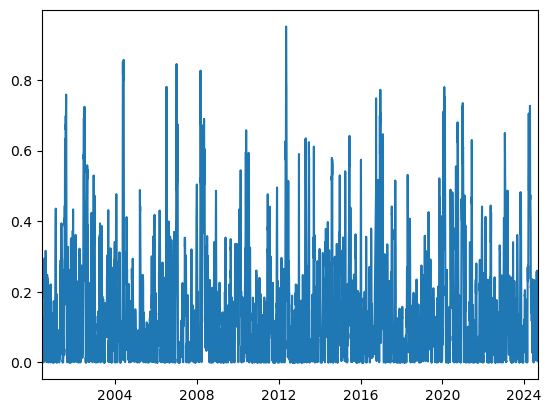

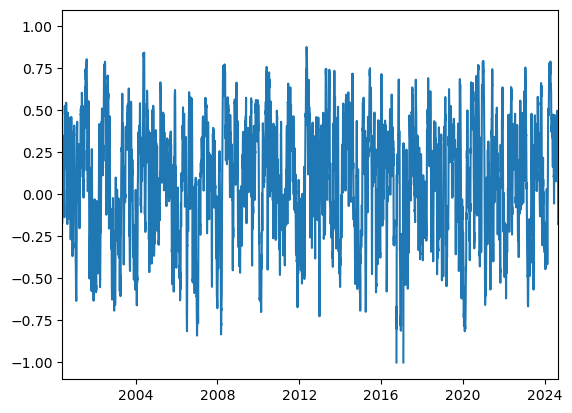

In [718]:
plt.plot(mutual_fano[242])
plt.xlim(np.datetime64('2000-06-01'), np.datetime64('2024-09-01'))
plt.show()

plt.plot(correlation_coeff[242])
plt.xlim(np.datetime64('2000-06-01'), np.datetime64('2024-09-01'))
plt.show()

In [726]:
# Precompute data for all frames
dates = np.arange(np.datetime64('2000-02-01'), np.datetime64('2001-01-01'))
precomputed_data_fano = {}
precomputed_data_mutual = {}
precomputed_data_corr = {}

vmax_fano = -np.inf
vmax_mutual = -np.inf

for date in dates:
    data_plot_fano = []
    data_plot_mutual = []
    data_plot_corr = []

    for stat_id in mutual_fano.keys():
        fano = mutual_fano[stat_id]
        mutual = mutual_info[stat_id]
        corr = correlation_coeff[stat_id]

        location = loc_dict[stat_id]
        values_fano = fano.values[fano.index == date]
        values_mutual = mutual.values[mutual.index == date]
        values_corr = corr.values[corr.index == date]
        
        if len(values_fano) != 0:
            if values_fano[0] != 0:
                data_plot_fano.append((location[0], location[1], values_fano[0]))
                if values_fano[0] > vmax_fano:
                    vmax_fano = values_fano[0]

        if len(values_mutual) != 0:
            if values_mutual[0] != 0 and ~np.isinf(values_mutual[0]):
                data_plot_mutual.append((location[0], location[1], values_mutual[0]))
                if values_mutual[0] > vmax_mutual:
                    vmax_mutual = values_mutual[0]

        if len(values_corr) != 0:
            if values_corr[0] != 0 and ~np.isinf(values_corr[0]):
                data_plot_corr.append((location[0], location[1], values_corr[0]))
            
        
    precomputed_data_fano[date] = np.array(data_plot_fano)
    precomputed_data_mutual[date] = np.array(data_plot_mutual)
    precomputed_data_corr[date] = np.array(data_plot_corr)

In [727]:
print(vmax_fano, vmax_mutual)

1.9398808115481503 16.633624400983198


In [728]:
all_fano_values = []
all_mutual_values = []
all_corr_values = []

for date, data in precomputed_data_fano.items():
    for i in range(len(data)):
        all_fano_values.append(data[i][2])

for date, data in precomputed_data_mutual.items():
    for i in range(len(data)):
        all_mutual_values.append(data[i][2])

for date, data in precomputed_data_corr.items():
    for i in range(len(data)):
        all_corr_values.append(data[i][2])

all_fano_values = np.array(all_fano_values)
all_fano_values = all_fano_values[~np.isnan(all_fano_values)].flatten()

all_mutual_values = np.array(all_mutual_values)
all_mutual_values = all_mutual_values[~np.isnan(all_mutual_values)].flatten()

all_corr_values = np.array(all_corr_values)
all_corr_values = all_corr_values[~np.isnan(all_corr_values)].flatten()

In [729]:
# compute the quantiles
np.quantile(all_fano_values, 0.9), np.quantile(all_mutual_values, 0.9), np.quantile(all_corr_values, 0.9)

(0.35831323885927074, 0.20437479710733278, 0.3017745053062075)

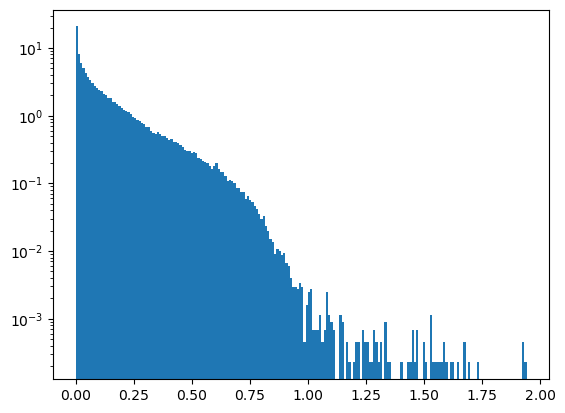

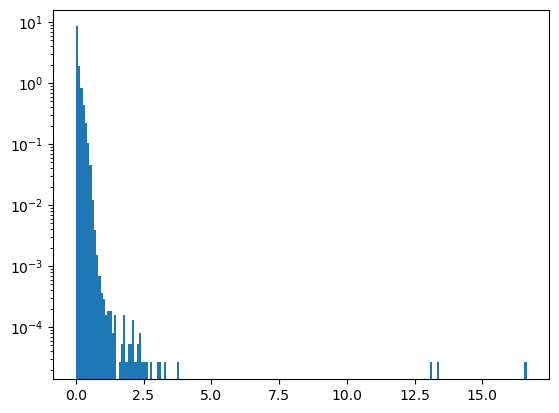

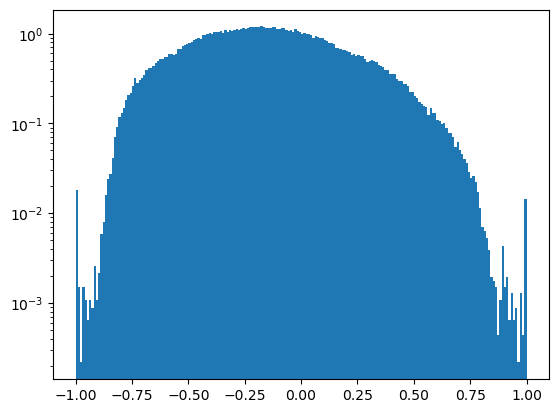

In [730]:
plt.hist(all_fano_values, bins = 200, density=True)
plt.yscale('log')
plt.show()

plt.hist(all_mutual_values, bins = 200, density=True)
plt.yscale('log')
plt.show()

plt.hist(all_corr_values, bins = 200, density=True)
plt.yscale('log')
plt.show()

In [692]:
import copy
testfano = copy.deepcopy(precomputed_data_fano)
# drop the first 30 dates
# for i in range(30):
#     test.pop(np.datetime64('2000-01-01') + np.timedelta64(i, 'D'))

th = 4

thfano = np.max(all_fano_values)/th

for date, data in testfano.items():
    for i in range(len(data)):
        if data[i][2] < thfano:
            data[i][2] = 0
        else:
            data[i][2] = 1

# testmutual = copy.deepcopy(precomputed_data_mutual)

# thmutual = np.max(all_fano_values)/th

# for date, data in testmutual.items():
#     for i in range(len(data)):
#         if data[i][2] < thmutual:
#             data[i][2] = 0
#         else:
#             data[i][2] = 1

In [693]:
date = np.datetime64('2005-01-07')
precomputed_data_fano[date], testfano[date]#, testmutual[date]

(array([[6.06166667e+01, 1.56166667e+01, 1.39465306e-02],
        [5.84000000e+01, 1.55166667e+01, 5.14284689e-03],
        [5.84000000e+01, 1.55166667e+01, 5.14284689e-03],
        ...,
        [4.59833333e+01, 1.82333333e+01, 2.62983140e-05],
        [4.82833333e+01, 2.07333333e+01, 1.60148749e-03],
        [6.11333333e+01, 1.13500000e+01, 1.52869697e-02]]),
 array([[60.61666667, 15.61666667,  0.        ],
        [58.4       , 15.51666667,  0.        ],
        [58.4       , 15.51666667,  0.        ],
        ...,
        [45.98333333, 18.23333333,  0.        ],
        [48.28333333, 20.73333333,  0.        ],
        [61.13333333, 11.35      ,  0.        ]]))

In [694]:
fraction_active_stations = []
num_active_stations = []

for date, data in testfano.items():
    active_stations = np.where(data[:,2] == 1)
    active_stations_fano = precomputed_data_fano[date][active_stations]

    fraction_active_stations.append(np.mean(active_stations_fano[:,2]) )
    num_active_stations.append(len(active_stations[0]))

fraction_active_stations = np.array(fraction_active_stations)
min_fraction = np.nanmin(fraction_active_stations)
max_fraction = np.nanmax(fraction_active_stations)

/Users/giorgionicoletti/miniconda3/envs/minpy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/giorgionicoletti/miniconda3/envs/minpy/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


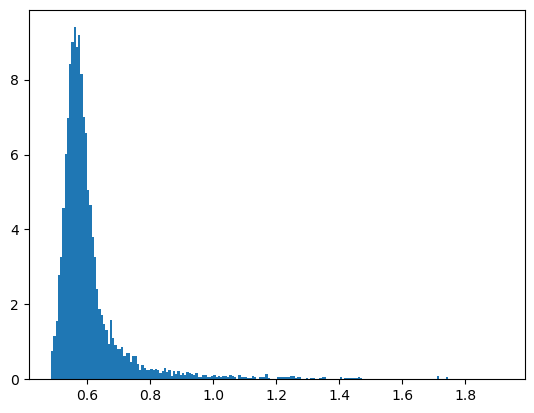

In [695]:
plt.hist(fraction_active_stations, density=True, bins=200)
plt.show()

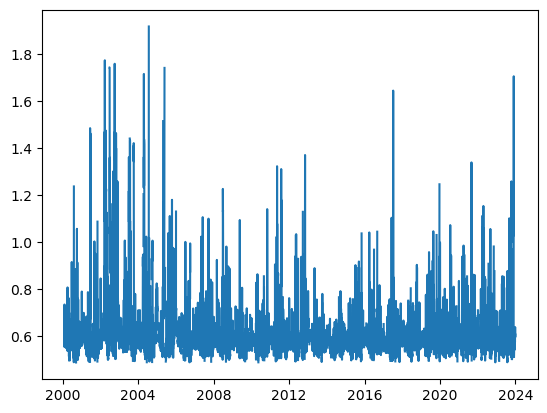

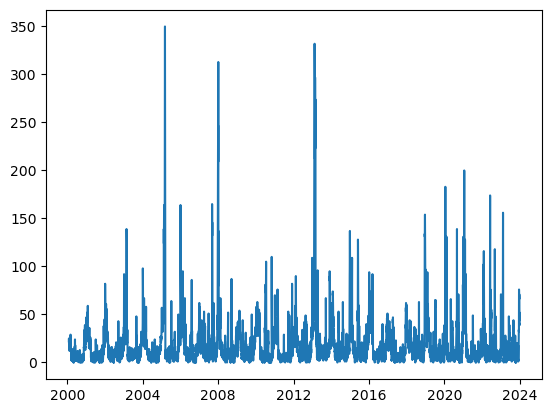

In [696]:
plt.plot(dates, fraction_active_stations)
plt.show()

plt.plot(dates, num_active_stations)
plt.show()

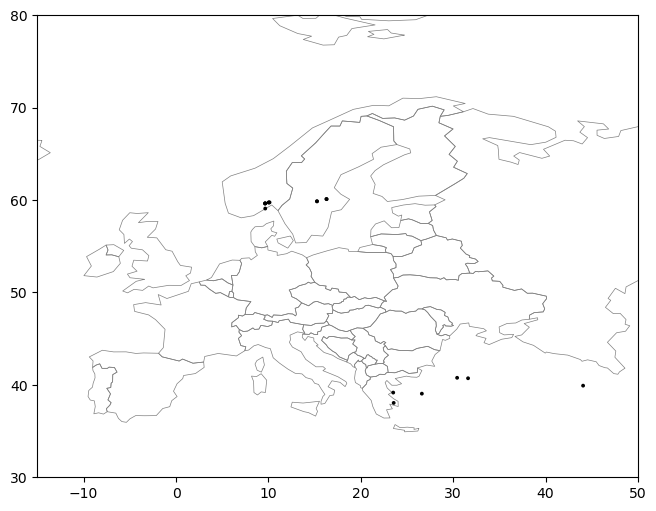

In [697]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
europe.boundary.plot(ax=ax, lw=0.5, color='gray', zorder=-np.inf)
ax.set_xlim(-15, 50)
ax.set_ylim(30, 80)
ax.set_aspect('equal')

# Initialize the scatter plots
cmap = plt.get_cmap('Greys')
cmap._init()
cmap._lut[:,-1] = np.sort(1 - np.geomspace(1e-2, 1, cmap.N + 3))
cmap.set_bad((0,0,0,0))

scat_fano = ax.scatter([], [], c=[], s=3, vmin=0, vmax=1, cmap=cmap)

date = np.datetime64('2023-07-15')
scat_fano.set_offsets(testfano[date][:, [1, 0]])
scat_fano.set_array(testfano[date][:, 2])

plt.show()

# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# europe.boundary.plot(ax=ax, lw=0.5, color='gray', zorder=-np.inf)
# ax.set_xlim(-15, 50)
# ax.set_ylim(30, 80)
# ax.set_aspect('equal')

# # Initialize the scatter plots
# cmap = plt.get_cmap('Greys')
# cmap._init()
# cmap._lut[:,-1] = np.sort(1 - np.geomspace(1e-2, 1, cmap.N + 3))
# cmap.set_bad((0,0,0,0))

# scat_fano = ax.scatter([], [], c=[], s=3, vmin=0, vmax=1, cmap=cmap)

# scat_fano.set_offsets(testmutual[date][:, [1, 0]])
# scat_fano.set_array(testmutual[date][:, 2])

# plt.show()

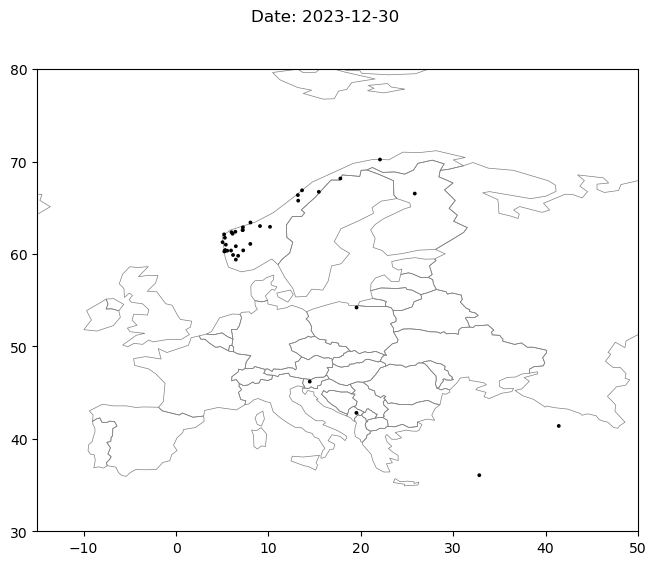

In [698]:
dates_animation = np.arange(np.datetime64('2022-01-01'), np.datetime64('2023-12-31'))


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
europe.boundary.plot(ax=ax, lw=0.5, color='gray', zorder=-np.inf)
ax.set_xlim(-15, 50)
ax.set_ylim(30, 80)
ax.set_aspect('equal')

# Initialize the scatter plots
cmap = plt.get_cmap('Greys')
cmap._init()
cmap._lut[:,-1] = np.sort(1 - np.geomspace(1e-2, 1, cmap.N + 3))
cmap.set_bad((0,0,0,0))

scat_fano = ax.scatter([], [], c=[], s=3, vmin=0, vmax=1, cmap=cmap)

def update(date):
    scat_fano.set_offsets(testfano[date][:, [1, 0]])
    scat_fano.set_array(testfano[date][:, 2])
    fig.suptitle(f"Date: {date}")
    return scat_fano,

ani = animation.FuncAnimation(fig, update, frames=dates_animation, blit=True, interval = 60)
ani.save('clusters_prec.mp4', writer='ffmpeg')

plt.show()

In [411]:
import matplotlib.animation as animation
import cmasher

Frame: 0, Date: 2000-02-01, Data Plot Fano Shape: (1349, 3), Data Plot Corr Shape: (1351, 3)
Frame: 1, Date: 2000-02-02, Data Plot Fano Shape: (1369, 3), Data Plot Corr Shape: (1371, 3)
Frame: 2, Date: 2000-02-03, Data Plot Fano Shape: (1364, 3), Data Plot Corr Shape: (1366, 3)
Frame: 3, Date: 2000-02-04, Data Plot Fano Shape: (1358, 3), Data Plot Corr Shape: (1360, 3)
Frame: 4, Date: 2000-02-05, Data Plot Fano Shape: (1365, 3), Data Plot Corr Shape: (1367, 3)
Frame: 5, Date: 2000-02-06, Data Plot Fano Shape: (1365, 3), Data Plot Corr Shape: (1367, 3)
Frame: 6, Date: 2000-02-07, Data Plot Fano Shape: (1372, 3), Data Plot Corr Shape: (1375, 3)
Frame: 7, Date: 2000-02-08, Data Plot Fano Shape: (1370, 3), Data Plot Corr Shape: (1373, 3)
Frame: 8, Date: 2000-02-09, Data Plot Fano Shape: (1360, 3), Data Plot Corr Shape: (1362, 3)
Frame: 9, Date: 2000-02-10, Data Plot Fano Shape: (1370, 3), Data Plot Corr Shape: (1372, 3)
Frame: 10, Date: 2000-02-11, Data Plot Fano Shape: (1366, 3), Data Plo

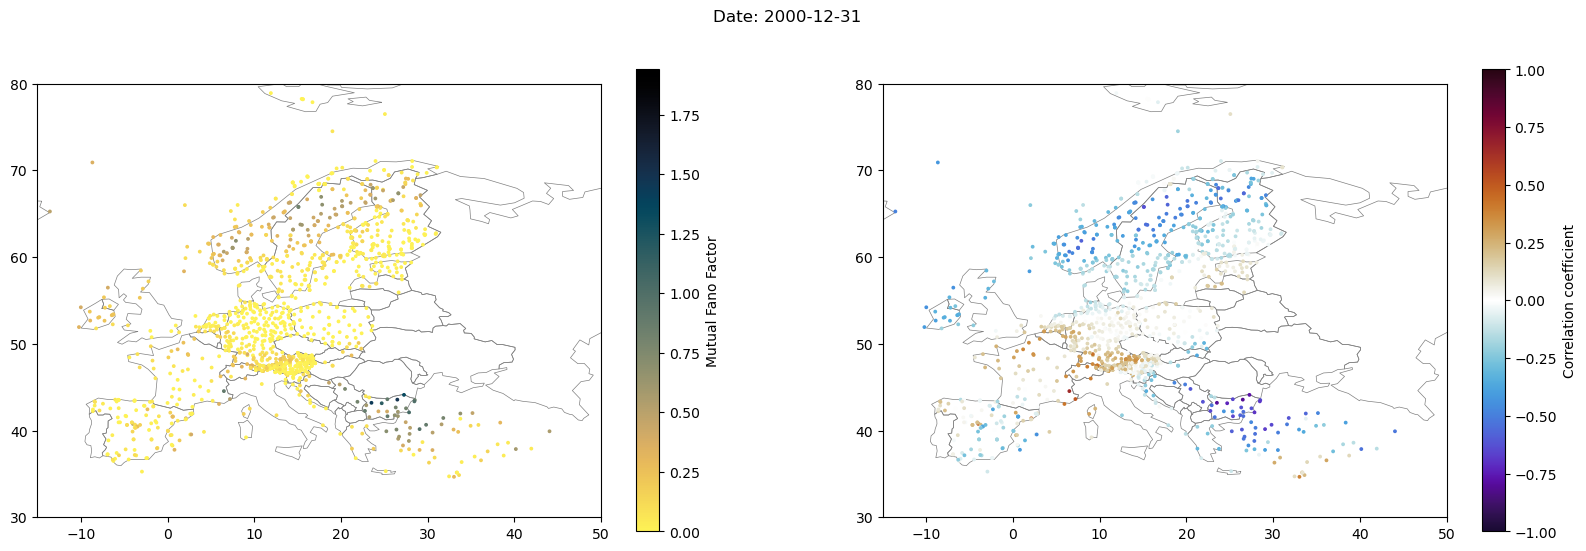

In [734]:
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
europe.boundary.plot(ax=ax1, lw=0.5, color='gray', zorder=-np.inf)
europe.boundary.plot(ax=ax2, lw=0.5, color='gray', zorder=-np.inf)
ax1.set_xlim(-15, 50)
ax1.set_ylim(30, 80)
ax2.set_xlim(-15, 50)
ax2.set_ylim(30, 80)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# Initialize the colormaps
cmap_fano = plt.get_cmap('cmr.eclipse_r')
cmap_fano.set_bad((0,0,0,0))

cmap_corr = plt.get_cmap('cmr.fusion_r')

# Create ScalarMappables for the colorbars
sm_fano = plt.cm.ScalarMappable(cmap=cmap_fano, norm=plt.Normalize(vmin=0, vmax=vmax_fano))
sm_fano.set_array([])
fig.colorbar(sm_fano, ax=ax1, label='Mutual Fano Factor')

sm_corr = plt.cm.ScalarMappable(cmap=cmap_corr, norm=plt.Normalize(vmin=-1, vmax=1))
sm_corr.set_array([])
fig.colorbar(sm_corr, ax=ax2, label='Correlation coefficient')

# Initialize the scatter plots
scat_fano = ax1.scatter([], [], c=[], s=3, vmin=0, vmax=1, cmap=cmap_fano)
scat_corr = ax2.scatter([], [], c=[], s=3, vmin=-1, vmax = 1, cmap=cmap_corr)

# Function to initialize the scatter plots
def init():
    scat_fano.set_offsets(np.empty((0, 2)))
    scat_fano.set_array(np.array([]))
    scat_corr.set_offsets(np.empty((0, 2)))
    scat_corr.set_array(np.array([]))
    return scat_fano, scat_corr

# Function to update the scatter plots for each frame
def update(frame):
    date = dates[frame]
    data_plot_fano = precomputed_data_fano[date]
    data_plot_corr = precomputed_data_corr[date]
    print(f"Frame: {frame}, Date: {date}, Data Plot Fano Shape: {data_plot_fano.shape}, Data Plot Corr Shape: {data_plot_corr.shape}")
    
    if data_plot_fano.ndim == 2 and data_plot_fano.shape[0] > 0:
        scat_fano.set_offsets(data_plot_fano[:, [1, 0]])
        scat_fano.set_array(data_plot_fano[:, 2])
    else:
        scat_fano.set_offsets(np.empty((0, 2)))
        scat_fano.set_array(np.array([]))
    if data_plot_corr.ndim == 2 and data_plot_corr.shape[0] > 0:
        scat_corr.set_offsets(data_plot_corr[:, [1, 0]])
        scat_corr.set_array(data_plot_corr[:, 2])
    else:
        scat_corr.set_offsets(np.empty((0, 2)))
        scat_corr.set_array(np.array([]))
    fig.suptitle(f"Date: {date}")
    return scat_fano, scat_corr

# Create the animation with a specified interval (e.g., 200 milliseconds)
ani = animation.FuncAnimation(fig, update, frames=len(dates), init_func=init, blit=True, interval=100)

# Save the animation as a video file (optional)
ani.save('animation_fano_corr_radiation_temperature.mp4', writer='ffmpeg')

plt.show()

Frame: 0, Date: 2000-01-01, Data Plot Fano Shape: (0,), Data Plot Mutual Shape: (0,)
Frame: 1, Date: 2000-01-02, Data Plot Fano Shape: (0,), Data Plot Mutual Shape: (0,)
Frame: 2, Date: 2000-01-03, Data Plot Fano Shape: (0,), Data Plot Mutual Shape: (0,)
Frame: 3, Date: 2000-01-04, Data Plot Fano Shape: (715, 3), Data Plot Mutual Shape: (715, 3)
Frame: 4, Date: 2000-01-05, Data Plot Fano Shape: (800, 3), Data Plot Mutual Shape: (798, 3)
Frame: 5, Date: 2000-01-06, Data Plot Fano Shape: (826, 3), Data Plot Mutual Shape: (825, 3)
Frame: 6, Date: 2000-01-07, Data Plot Fano Shape: (825, 3), Data Plot Mutual Shape: (825, 3)
Frame: 7, Date: 2000-01-08, Data Plot Fano Shape: (824, 3), Data Plot Mutual Shape: (824, 3)
Frame: 8, Date: 2000-01-09, Data Plot Fano Shape: (834, 3), Data Plot Mutual Shape: (834, 3)
Frame: 9, Date: 2000-01-10, Data Plot Fano Shape: (831, 3), Data Plot Mutual Shape: (830, 3)
Frame: 10, Date: 2000-01-11, Data Plot Fano Shape: (827, 3), Data Plot Mutual Shape: (827, 3)


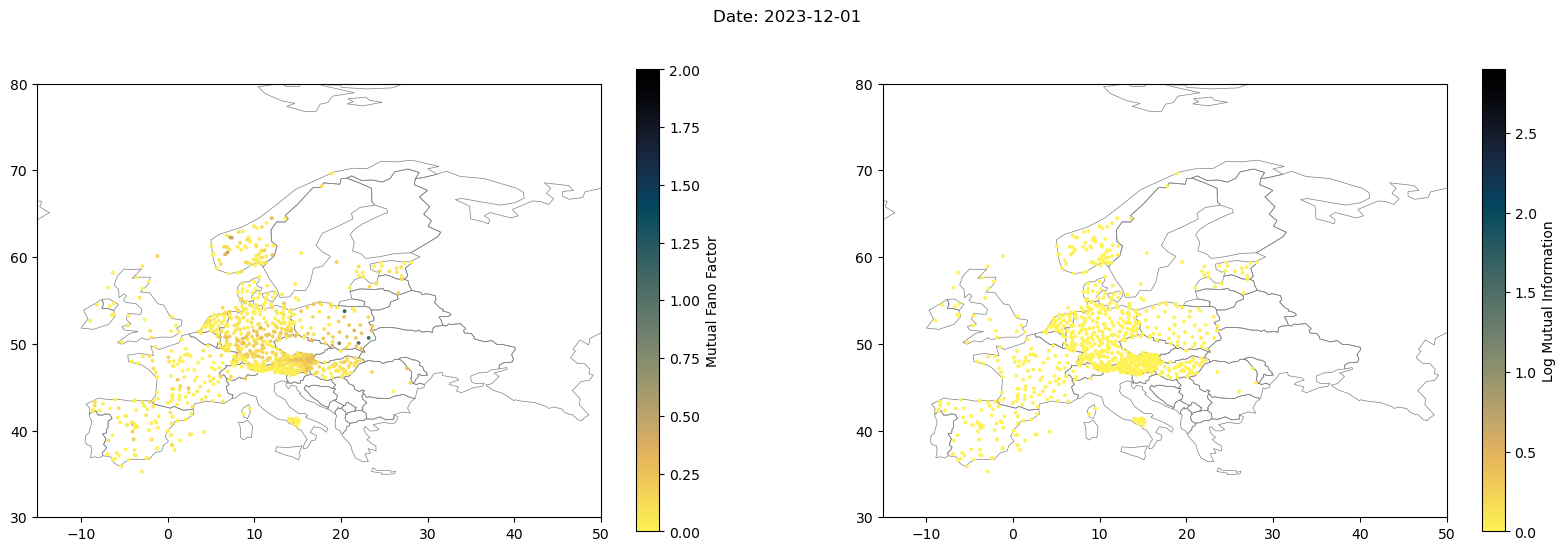

In [ ]:
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
europe.boundary.plot(ax=ax1, lw=0.5, color='gray', zorder=-np.inf)
europe.boundary.plot(ax=ax2, lw=0.5, color='gray', zorder=-np.inf)
ax1.set_xlim(-15, 50)
ax1.set_ylim(30, 80)
ax2.set_xlim(-15, 50)
ax2.set_ylim(30, 80)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# Initialize the colormaps
cmap = plt.get_cmap('cmr.eclipse_r')
cmap.set_bad((0,0,0,0))

# Create ScalarMappables for the colorbars
sm_fano = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax_fano))
sm_fano.set_array([])
fig.colorbar(sm_fano, ax=ax1, label='Mutual Fano Factor')

sm_mutual = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=np.log(vmax_mutual)))
sm_mutual.set_array([])
fig.colorbar(sm_mutual, ax=ax2, label='Log Mutual Information')

# Initialize the scatter plots
scat_fano = ax1.scatter([], [], c=[], s=3, vmin=0, vmax=vmax_fano, cmap=cmap)
scat_mutual = ax2.scatter([], [], c=[], s=3, vmin=0, vmax=np.log(vmax_mutual), cmap=cmap)

# Function to initialize the scatter plots
def init():
    scat_fano.set_offsets(np.empty((0, 2)))
    scat_fano.set_array(np.array([]))
    scat_mutual.set_offsets(np.empty((0, 2)))
    scat_mutual.set_array(np.array([]))
    return scat_fano, scat_mutual

# Function to update the scatter plots for each frame
def update(frame):
    date = dates[frame]
    data_plot_fano = precomputed_data_fano[date]
    data_plot_mutual = precomputed_data_mutual[date]
    print(f"Frame: {frame}, Date: {date}, Data Plot Fano Shape: {data_plot_fano.shape}, Data Plot Mutual Shape: {data_plot_mutual.shape}")
    if data_plot_fano.ndim == 2 and data_plot_fano.shape[0] > 0:
        scat_fano.set_offsets(data_plot_fano[:, [1, 0]])
        scat_fano.set_array(data_plot_fano[:, 2])
    else:
        scat_fano.set_offsets(np.empty((0, 2)))
        scat_fano.set_array(np.array([]))
    if data_plot_mutual.ndim == 2 and data_plot_mutual.shape[0] > 0:
        scat_mutual.set_offsets(data_plot_mutual[:, [1, 0]])
        scat_mutual.set_array(np.log(data_plot_mutual[:, 2]))
    else:
        scat_mutual.set_offsets(np.empty((0, 2)))
        scat_mutual.set_array(np.array([]))
    fig.suptitle(f"Date: {date}")
    return scat_fano, scat_mutual

# Create the animation with a specified interval (e.g., 200 milliseconds)
ani = animation.FuncAnimation(fig, update, frames=len(dates), init_func=init, blit=True, interval=100)

# Save the animation as a video file (optional)
ani.save('animation_fano_mutual_radiation_temperature.mp4', writer='ffmpeg')

plt.show()